In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from skimage.transform import resize
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, col
from pyspark.sql import Row
from pyspark.sql.functions import count
from pyspark.ml.linalg import Vectors

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import seaborn as sns
import shutil

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("YourAppName").getOrCreate()

train_path = "/Users/sailaharimullapudi/Desktop/kneeKL224_test/train"
test_path = "/Users/sailaharimullapudi/Desktop/kneeKL224_test/test"
valid_path = "/Users/sailaharimullapudi/Desktop/kneeKL224_test/val"
list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

24/01/20 17:10:59 WARN Utils: Your hostname, Sailaharis-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.0.0.132 instead (on interface en0)
24/01/20 17:10:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/20 17:11:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
paths = [train_path, test_path, valid_path]

for path in paths:
    filepaths = []
    labels = []
    classlist = [klass for klass in os.listdir(path) if not klass.startswith('.')]
    
    for klass in classlist:
        intklass = int(klass)
        label = list_of_classes[intklass]
        classpath = os.path.join(path, klass)
        flist = os.listdir(classpath)
        
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(label)
    
    rows = [Row(filepaths=filepaths[i], labels=labels[i]) for i in range(len(filepaths))]
    spark_df = spark.createDataFrame(rows)
    
    if path == test_path:
        test_df = spark_df
    elif path == valid_path:
        valid_df = spark_df
    else:
        train_df = spark_df


In [4]:
print('train_df length:', train_df.count(), '  test_df length:', test_df.count(), '  valid_df length:', valid_df.count())

train_df length: 2658   test_df length: 1191   valid_df length: 826


In [5]:
class_counts = train_df.groupBy('labels').agg(count('*').alias('image_count'))
class_count = class_counts.count()
print('The number of classes in the dataset is:', class_count)
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for row in class_counts.collect():
    label = row['labels']
    count_value = row['image_count']
    print('{0:^30s} {1:^13s}'.format(str(label), str(count_value)))

The number of classes in the dataset is: 5
            CLASS               IMAGE COUNT 
           Healthy                  584     
           Doubtful                 513     
            Severe                  173     
           Moderate                 757     
           Minimal                  631     


In [6]:
ht = 0
wt = 0

def get_image_shape(fpath):
    img = plt.imread(fpath)
    return img.shape

get_image_shape_udf = spark.udf.register("get_image_shape", get_image_shape)
train_df_sample = train_df.sample(withReplacement=False, fraction=0.01, seed=123)
train_df_sample = train_df_sample.withColumn("image_shape", get_image_shape_udf(col("filepaths")))

for row in train_df_sample.collect():
    shape = row["image_shape"]
    
    if isinstance(shape, list):
        ht += int(shape[0][0]) 
        wt += int(shape[0][1]) 
    elif isinstance(shape, tuple):
        ht += int(shape[0])  
        wt += int(shape[1])  

24/01/20 17:11:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [7]:
average_height = ht // 100
average_width = wt // 100
image_size = (average_height, average_width)

In [8]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("image_processing").getOrCreate()
sc = SparkContext.getOrCreate()

def preprocess(filepath):
    img = plt.imread(filepath)
    img = resize(img, image_size, anti_aliasing=True)
    img_flat = img.flatten()
    return img_flat

def process_images(filepaths):
    # Parallelize the file paths
    rdd = sc.parallelize(filepaths)

    # Use map to apply the preprocess function to each file path in parallel
    processed_images_rdd = rdd.map(preprocess)

    # Collect the results into a list
    processed_images = processed_images_rdd.collect()

    return processed_images

24/01/20 17:11:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [9]:
from pyspark.sql.types import ArrayType, FloatType
preprocess_udf = udf(preprocess, ArrayType(FloatType()))

In [10]:
train_df = train_df.withColumn('processed_images', preprocess_udf('filepaths'))
test_df = test_df.withColumn('processed_images', preprocess_udf('filepaths'))
valid_df = valid_df.withColumn('processed_images', preprocess_udf('filepaths'))

In [11]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession

label_indexer = StringIndexer(inputCol="labels", outputCol="indexed_labels")
test_indexer = StringIndexer(inputCol="labels", outputCol="indexed_labels")
valid_indexer = StringIndexer(inputCol="labels", outputCol="indexed_labels")

train_spark_df = label_indexer.fit(train_df).transform(train_df)
test_spark_df = test_indexer.fit(train_df).transform(test_df)
valid_spark_df = valid_indexer.fit(train_df).transform(valid_df)

train_spark_df.select("labels", "indexed_labels").show()

train_labels = train_spark_df.select("indexed_labels")
test_labels = test_spark_df.select("indexed_labels")
valid_labels = valid_spark_df.select("indexed_labels")

+-------+--------------+
| labels|indexed_labels|
+-------+--------------+
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
|Healthy|           2.0|
+-------+--------------+
only showing top 20 rows



In [12]:
from pyspark.ml.linalg import Vectors, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [13]:
vector_assembler = VectorAssembler(inputCols=["indexed_labels"], outputCol="features")
logistic_regression = LogisticRegression(labelCol="indexed_labels", featuresCol="features", 
                                         maxIter=10, regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[vector_assembler, logistic_regression])

In [14]:
model = pipeline.fit(train_spark_df)

24/01/20 17:11:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/20 17:11:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [15]:
predictions = model.transform(test_spark_df)
result = MulticlassClassificationEvaluator(labelCol="indexed_labels", predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = result.evaluate(predictions)
print("Test Accuracy: {:.2%}".format(accuracy))

Test Accuracy: 18.81%


In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="indexed_labels", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
weightedF1 = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFMeasure"})

print("\nSummary Statistics:")
print("Accuracy = {:.2%}".format(accuracy))
print("Weighted Precision = {:.2%}".format(weightedPrecision))
print("Weighted Recall = {:.2%}".format(weightedRecall))
print("Weighted F1 Score = {:.2%}".format(weightedF1))

confusion_matrix = predictions.groupBy("indexed_labels", "prediction").count().orderBy("indexed_labels", "prediction")
confusion_matrix.show()



Summary Statistics:
Accuracy = 18.81%
Weighted Precision = 6.28%
Weighted Recall = 18.81%
Weighted F1 Score = 9.41%
+--------------+----------+-----+
|indexed_labels|prediction|count|
+--------------+----------+-----+
|           0.0|       0.0|  224|
|           1.0|       0.0|  447|
|           2.0|       1.0|  172|
|           3.0|       1.0|  296|
|           4.0|       1.0|   52|
+--------------+----------+-----+




Summary Statistics:
Accuracy = 18.81%
Weighted Precision = 6.28%
Weighted Recall = 18.81%
Weighted F1 Score = 9.41%


/var/folders/9g/rbhjcmds0jqbn2p1t17vl84m0000gn/T/ipykernel_83729/1636539049.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  conf_matrix_heatmap = confusion_matrix_pd.pivot("indexed_labels", "prediction", "count").fillna(0)


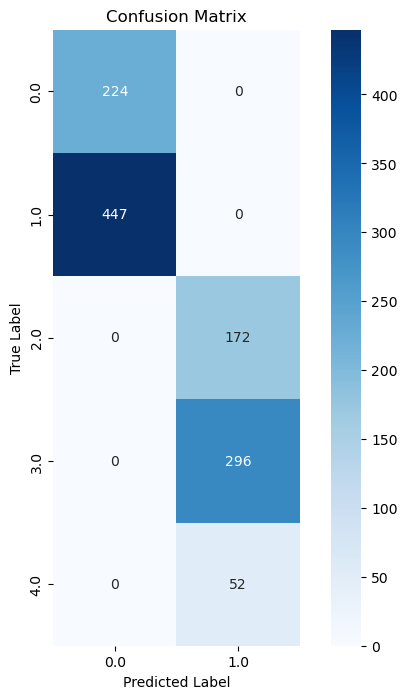

In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns
import matplotlib.pyplot as plt

evaluator = MulticlassClassificationEvaluator(labelCol="indexed_labels", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
weightedF1 = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFMeasure"})

print("\nSummary Statistics:")
print("Accuracy = {:.2%}".format(accuracy))
print("Weighted Precision = {:.2%}".format(weightedPrecision))
print("Weighted Recall = {:.2%}".format(weightedRecall))
print("Weighted F1 Score = {:.2%}".format(weightedF1))

confusion_matrix = predictions.groupBy("indexed_labels", "prediction").count().orderBy("indexed_labels", "prediction")
confusion_matrix_pd = confusion_matrix.toPandas()
conf_matrix_heatmap = confusion_matrix_pd.pivot("indexed_labels", "prediction", "count").fillna(0)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_heatmap, annot=True, fmt="g", cmap="Blues", cbar=True, square=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
